# ANAC


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import skew, kurtosis

#### Seed

In [158]:
seed = 2024
np.random.seed(seed)

In [173]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_12512\3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


### Data Cleaning

#### Basics

In [174]:
# Rename columns
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
requests_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

# Change types of Diet & RecipeCategory into category
diet_csv["Diet"] = diet_csv["Diet"].astype("category")
recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")

# Change types to boolean
requests_csv["HighCalories"] = requests_csv["HighCalories"].astype("bool")
requests_csv["LowFat"] = requests_csv["LowFat"].astype("bool")
requests_csv["HighFiber"] = requests_csv["HighFiber"].astype("bool")
reviews_csv["Like"] = reviews_csv["Like"].astype("boolean")

# Remove NA rows and Rating column and TestSetId
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv = reviews_csv.drop("TestSetId", axis=1)

### Missing values

In [175]:
diet_csv['Diet'].fillna('Vegetarian', inplace=True)
# diet_csv = diet_csv.dropna(axis="rows")

reviews_csv.dropna(subset=["Like"], inplace=True)

# Map indifferent values for HighProtein and LowSugar
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
requests_csv["HighProtein"] = requests_csv["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
requests_csv["LowSugar"] = requests_csv["LowSugar"].map(mapping_sugar).astype('category')



#### Join the tables

In [176]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="CustomerId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["CustomerId", "RecipeId"])
# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar"], drop_first=True)
df

,CustomerId,RecipeId,Like,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,...,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,HighProtein_Yes,LowSugar_No
0,1000036C,320576,False,Downeaster,0,120,"""2""","c(""\""vodka\"""", ""\""cranberry juice\"""", ""\""lime ...",138.7,0.0,...,False,True,False,False,False,False,False,False,False,False
1,1000216B,189335,False,Thai Rice Soup (Kao Tome Gai),600,600,"c(""\""6\"""", ""\""4\"""", ""\""8\"""", ""\""4\"""", ""\""1/2\""...","c(""\""garlic\"""", ""\""cooked rice\"""", ""\""ground c...",395.7,19.2,...,False,True,False,False,False,False,True,False,True,True
2,1000221A,133043,False,Lemon and Thyme Marinade for Poultry,60,300,"c(""\""4\"""", ""\""4\"""", ""\""4\"""")","c(""\""lemon juice\"""", ""\""fresh thyme\"""", ""\""dri...",125.6,13.5,...,False,True,False,False,False,False,True,False,True,False
3,1000221A,90537,False,Black Bean Salsa,0,1200,"c(""\""2\"""", ""\""1\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\""...","c(""\""black beans\"""", ""\""frozen corn\"""", ""\""gre...",1590.1,49.0,...,False,True,False,True,False,False,False,False,True,True
4,1000221A,334314,False,Irish Soda Bread,3600,1800,"c(""\""3\"""", ""\""2/3\"""", ""\""3\"""", ""\""1\"""", ""\""1/2...","c(""\""flour\"""", ""\""sugar\"""", ""\""baking powder\""...",770.9,11.0,...,False,True,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97376,999595E,338070,False,Pumpkin Cake Mix Dessert,3000,900,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...","c(""\""pumpkin puree\"""", ""\""evaporated milk\"""", ...",464.3,31.4,...,False,True,False,False,False,False,True,False,False,False
97377,999774A,29002,False,Summer Corkscrew Pasta,1200,1200,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...","c(""\""corkscrew macaroni\"""", ""\""zucchini\"""", ""\...",838.5,33.3,...,False,True,False,False,False,False,True,False,False,False
97378,999774A,159252,False,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")","c(""\""kaffir lime leaves\"""", ""\""apples\"""", ""\""l...",928.0,0.6,...,False,True,False,False,False,False,True,False,True,True
97379,999774A,1171,True,Kahlua Hot Chocolate,360,120,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...","c(""\""sugar\"""", ""\""ground cinnamon\"""", ""\""groun...",665.9,19.8,...,False,True,False,False,False,False,False,False,True,True


In [177]:
maxtime_val = df['Time'].max()
outliers = df['Time'] >= maxtime_val
median_without_outliers = df.loc[~outliers, 'Time'].median()
df.loc[outliers, 'Time'] = median_without_outliers

maxtime_val = df['PrepTime'].max()
outliers = df['PrepTime'] >= maxtime_val
median_without_outliers = df.loc[~outliers, 'PrepTime'].median()
df.loc[outliers, 'PrepTime'] = median_without_outliers
outliers = (df['Like'] == True) & (df['PrepTime'] > 3000000)
df.loc[outliers, 'PrepTime'] = median_without_outliers

outliers = (df['Like'] == True) & (df['Calories'] > 30000)
median_without_outliers = df.loc[~outliers, 'Calories'].median()
df.loc[outliers, 'Calories'] = median_without_outliers

outliers = df['FatContent'] > 25000
median_without_outliers = df.loc[~outliers, 'FatContent'].median()
df.loc[outliers, 'FatContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['FatContent'] > 2500)
df.loc[outliers, 'FatContent'] = median_without_outliers

outliers = df['SaturatedFatContent'] > 12000
median_without_outliers = df.loc[~outliers, 'SaturatedFatContent'].median()
df.loc[outliers, 'SaturatedFatContent'] = median_without_outliers

outliers = df['CholesterolContent'] > 35000
median_without_outliers = df.loc[~outliers, 'CholesterolContent'].median()
df.loc[outliers, 'CholesterolContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['CholesterolContent'] > 10000)
df.loc[outliers, 'CholesterolContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['CarbohydrateContent'] > 4000)
median_without_outliers = df.loc[~outliers, 'CarbohydrateContent'].median()
df.loc[outliers, 'CarbohydrateContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['FiberContent'] > 400)
median_without_outliers = df.loc[~outliers, 'FiberContent'].median()
df.loc[outliers, 'FiberContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['SugarContent'] > 4000)
median_without_outliers = df.loc[~outliers, 'SugarContent'].median()
df.loc[outliers, 'SugarContent'] = median_without_outliers

outliers = df['ProteinContent'] > 17500
median_without_outliers = df.loc[~outliers, 'ProteinContent'].median()
df.loc[outliers, 'ProteinContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['ProteinContent'] > 3000)
df.loc[outliers, 'ProteinContent'] = median_without_outliers

outliers = df['RecipeServings'] > 30000
median_without_outliers = df.loc[~outliers, 'RecipeServings'].median()
df.loc[outliers, 'RecipeServings'] = median_without_outliers
outliers = (df['Like'] == True) & (df['RecipeServings'] > 400)
df.loc[outliers, 'RecipeServings'] = median_without_outliers

In [178]:
# needs to be done after outlier removal
recipesServings_mean = df['RecipeServings'].mean()
#fill na rows with the mean
df['RecipeServings'].fillna(recipesServings_mean, inplace=True)

In [179]:
# Add additional varibale for difference in requested time and recipe time
df["DifferenceRequestedAndTimeNeeded"] = df["Time"] - (df["CookTime"] + df["PrepTime"])

***Train Model***


In [180]:
X = df.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', 'RecipeServings'], axis=1)
y = df['Like']

In [181]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

In [168]:
train_model = RandomForestClassifier(n_estimators=100, random_state=seed)

train_model.fit(X_train,y_train)

# Calculate balanced accuracy
pred = train_model.predict(X_test)
score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

KeyboardInterrupt: 

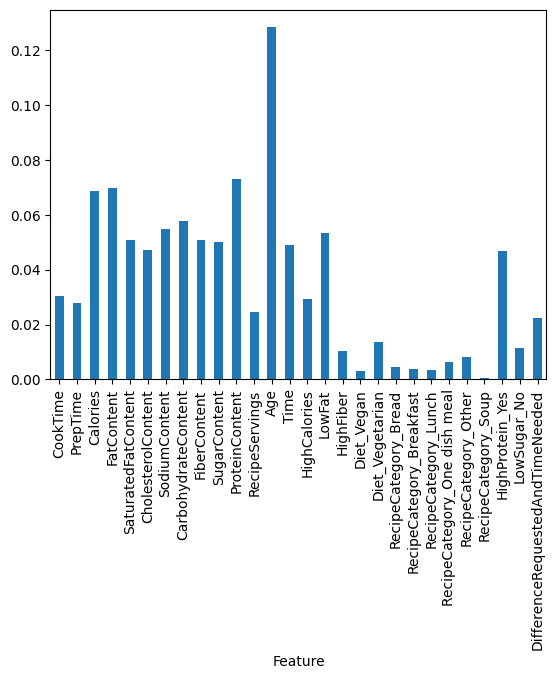

In [130]:
# Plot feature importance 

importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

***Test Model***

In [131]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
20653  False             0.0                0.99                0.01
82063  False             0.0                0.88                0.12
85333  False             0.0                0.95                0.05
96197  False             0.0                0.97                0.03
83016  False             0.0                0.83                0.17
...      ...             ...                 ...                 ...
47865  False             0.0                0.93                0.07
22491   True             0.0                0.90                0.10
10052  False             0.0                1.00                0.00
44580  False             0.0                0.89                0.11
4127   False             0.0                0.96                0.04

[29215 rows x 4 columns]
Confusion Matrix:
[[24797   580]
 [ 2414  1424]]
Test-Precision: 0.7105788423153693
Test-Accuracy: 0.8975183980831765
Test-Recall: 0.3710265763418

***TestSet***

In [182]:
# Gradient Boosting

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.6, random_state=seed)

train_model.fit(X_train,y_train)

score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

Cross validation score for balanced accuracy: 0.6976384377353744


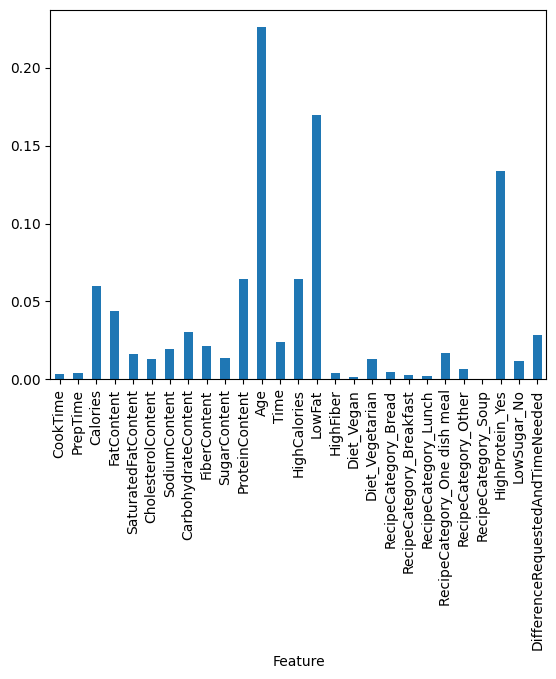

In [183]:
# Plot feature importance 
importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

In [184]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
20653  False             0.0        9.765633e-01            0.023437
82063  False             0.0        9.677520e-01            0.032248
85333  False             0.0        9.993202e-01            0.000680
96197  False             0.0        9.855896e-01            0.014410
83016  False             1.0        6.378662e-10            1.000000
...      ...             ...                 ...                 ...
47865  False             0.0        9.506268e-01            0.049373
22491   True             0.0        7.879268e-01            0.212073
10052  False             0.0        9.930400e-01            0.006960
44580  False             0.0        8.450673e-01            0.154933
4127   False             0.0        9.875551e-01            0.012445

[29215 rows x 4 columns]
Confusion Matrix:
[[24496   881]
 [ 2114  1724]]
Test-Precision: 0.6618042226487524
Test-Accuracy: 0.8974841690912203
Test-Recall: 0.4491922876498


#### 1. Logistic Regression
#### 2. Decision Trees
#### 3. Random Forest
#### 4. Naive bayes
#### 5. Gradient Boosting

#### 1. Data Cleaning (missing values, merge tables)
#### 2. Set dataset into training & testing sets + download testing set
#### 3. modeling
#### 4. Model training: train model on training dataset
#### 5. Model evaluation (performance)
#### 6. prediction on the unseen data

***Output file with test set***

In [186]:
diet_csv = pd.read_csv('diet.csv')
reviews_csv = pd.read_csv('reviews.csv')
requests_csv = pd.read_csv('requests.csv')
recipes_csv = pd.read_csv('recipes.csv')
testset = pd.read_csv("pub_YwCznU3.csv")

df_merge_1 = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
df_merge_2 = pd.merge(df_merge_1, recipes_csv, how="inner", on="RecipeId")
df_merge_3 = pd.merge(df_merge_2, reviews_csv, how="inner", on=["AuthorId", "RecipeId"])

df_merge_3.rename(columns= {"TestSetId" : "id"}, inplace=True)

df_test = pd.merge(df_merge_3, testset, how="inner", on="id")
df_test["id"].astype("int")
df_test["Diet"].astype("category")
df_test["RecipeCategory"].astype("category")
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
df_test["HighProtein"] = df_test["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
df_test["LowSugar"] = df_test["LowSugar"].map(mapping_sugar).astype('category')

df_test["DifferenceRequestedAndTimeNeeded"] = df_test["Time"] - (df_test["CookTime"] + df_test["PrepTime"])

df_test = df_test.drop(['AuthorId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield',"id","prediction", "Rating", "RecipeServings"], axis=1)
df_test = pd.get_dummies(df_test, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar"], drop_first=True)
df_test = df_test.reindex(columns=["CookTime", "PrepTime", "Calories", "FatContent", "SaturatedFatContent", "CholesterolContent", 'SodiumContent', "CarbohydrateContent", "FiberContent", "SugarContent", "ProteinContent", "Age","Time","HighCalories","LowFat","HighFiber","Diet_Vegan", "Diet_Vegetarian", "RecipeCategory_Bread", "RecipeCategory_Breakfast", "RecipeCategory_Lunch", "RecipeCategory_One dish meal", "RecipeCategory_Other", "RecipeCategory_Soup", "HighProtein_Yes", "LowSugar_No", 'DifferenceRequestedAndTimeNeeded'])

predictions = train_model.predict(df_test)

output = pd.DataFrame(predictions)
output['id'] = df_test.index
output = output.rename(columns={'predictions': 'prediction'})
output = output.reindex(columns=["id", "prediction"])
output.to_csv("predictions_LetsSeePaulAllens'BAC_1.csv", index=False)


C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_12512\2365323449.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv('reviews.csv')
